In [148]:
from datetime import date, datetime, time, timedelta, timezone

import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize

plt.rcParams["font.family"] = "Source Han Sans CN"
plt.rcParams["figure.dpi"] = 150

CST = timezone(timedelta(hours=8), "中国标准时间")


In [149]:
dt = datetime.fromisoformat("2015-04-18 00:00:00+08:00")

time_str = """
14:42
14:45
14:48
14:51
14:54
14:57
15:00
15:03
15:06
15:09
15:12
15:15
15:18
15:21
15:24
15:27
15:30
15:33
15:36
15:39
15:42
"""
times = []
for t_str in time_str.strip().split("\n"):
    h, m = map(int, t_str.split(":"))
    times.append(dt.replace(hour=h, minute=m))
times = np.array(times)

xy_str = """
1.0365	0.4973
1.0699	0.5029
1.1038	0.5085
1.1383	0.5142
1.1732	0.5198
1.2087	0.5255
1.2448	0.5311
1.2815	0.5368
1.3189	0.5426
1.3568	0.5483
1.3955	0.5541
1.4349	0.5598
1.4751	0.5657
1.516	0.5715
1.5577	0.5774
1.6003	0.5833
1.6438	0.5892
1.6882	0.5952
1.7337	0.6013
1.7801	0.6074
1.8277	0.6135
"""
xs = []
ys = []
for line in xy_str.strip().split("\n"):
    x, y = map(float, line.split())
    xs.append(x)
    ys.append(y)
xs = np.array(xs)
ys = np.array(ys)


In [150]:
# 模型

march_equinox_2015 = datetime.fromisoformat("2015-03-20 22:45+00:00")
march_equinox_2015_timestamp = march_equinox_2015.timestamp()
"""2015年春分时间戳"""   # 时间戳：从 1970-01-01 00:00:00 UTC 开始的秒数
march_equinox_2015_noon_timestamp = march_equinox_2015.astimezone(CST).replace(hour=12, minute=0, second=0).timestamp()
"""2015年春分当天东经 120° 正午时间戳"""
obliquity_of_the_ecliptic = np.deg2rad(23.44)
"""黄赤交角"""
seconds_per_day = 86400
days_per_year = 365


def hour_angle(timestamp, longitude):
    """时角"""
    # timestamp % 86400 == 43200 时，子午线的时角为 0
    return (timestamp % seconds_per_day / seconds_per_day - 1/2) * 2 * np.pi + longitude


def declination(timestamp):
    """赤纬角，文稿的模型假设一天内赤纬角是常数"""
    day = np.round((timestamp - march_equinox_2015_noon_timestamp) / seconds_per_day)  # 2015 年春分后的天数
    return np.arcsin(np.sin(day / days_per_year * 2 * np.pi) * np.sin(obliquity_of_the_ecliptic))


def solar_elevation_angle(timestamp, longitude, latitude):
    """太阳高度角"""
    dec = declination(timestamp)
    ha = hour_angle(timestamp, longitude)
    return np.arcsin(np.cos(latitude) * np.cos(dec) * np.cos(ha) + np.sin(latitude) * np.sin(dec))


def shadow_length(timestamp, longitude, latitude):
    """单位长度的竖直直杆的影子的长度"""
    elev = solar_elevation_angle(timestamp, longitude, latitude)
    return np.where(elev > 0, np.cos(elev) / np.sin(elev), np.nan)  # not 1 / np.tan(elev) to avoid division by zero


def shadow_azimuth(timestamp, longitude, latitude):
    """影子的方位角"""
    dec = declination(timestamp)
    ha = hour_angle(timestamp, longitude)
    elev = solar_elevation_angle(timestamp, longitude, latitude)
    cos_azi = (np.cos(dec) * np.cos(ha) * np.sin(latitude) - np.sin(dec) * np.cos(latitude)) / np.cos(elev)
    sin_azi = np.sin(ha) * np.cos(dec) / np.cos(elev)
    return np.arctan2(sin_azi, cos_azi)


def shadow_position(timestamp, longitude, latitude):
    """单位长度的竖直直杆的影子的坐标（北，东）"""
    shadow_length_theoretical = shadow_length(timestamp, longitude, latitude)
    shadow_azimuth_theoretical = shadow_azimuth(timestamp, longitude, latitude)
    north_theoretical = shadow_length_theoretical * np.cos(shadow_azimuth_theoretical)
    east_theoretical = shadow_length_theoretical * np.sin(shadow_azimuth_theoretical)
    return np.array((north_theoretical, east_theoretical))


时间	影子长度（米）	影子方位角（度）	影子北坐标（米）	影子东坐标（米）
2015-10-22 09:00:00+08:00	7.7666	-51.8230	4.8005	-6.1054
2015-10-22 09:03:00+08:00	7.5886	-51.2019	4.7549	-5.9143
2015-10-22 09:06:00+08:00	7.4191	-50.5756	4.7115	-5.7309
2015-10-22 09:09:00+08:00	7.2573	-49.9441	4.6703	-5.5549
2015-10-22 09:12:00+08:00	7.1029	-49.3072	4.6311	-5.3855
2015-10-22 09:15:00+08:00	6.9554	-48.6649	4.5938	-5.2225
2015-10-22 09:18:00+08:00	6.8144	-48.0171	4.5582	-5.0654
2015-10-22 09:21:00+08:00	6.6794	-47.3637	4.5243	-4.9139
2015-10-22 09:24:00+08:00	6.5502	-46.7047	4.4919	-4.7675
2015-10-22 09:27:00+08:00	6.4264	-46.0400	4.4610	-4.6259
2015-10-22 09:30:00+08:00	6.3078	-45.3695	4.4314	-4.4889
2015-10-22 09:33:00+08:00	6.1939	-44.6932	4.4032	-4.3563
2015-10-22 09:36:00+08:00	6.0847	-44.0110	4.3762	-4.2276
2015-10-22 09:39:00+08:00	5.9798	-43.3228	4.3503	-4.1028
2015-10-22 09:42:00+08:00	5.8791	-42.6287	4.3256	-3.9816
2015-10-22 09:45:00+08:00	5.7823	-41.9285	4.3019	-3.8637
2015-10-22 09:48:00+08:00	5.6892	-41.2222	4.2792	-

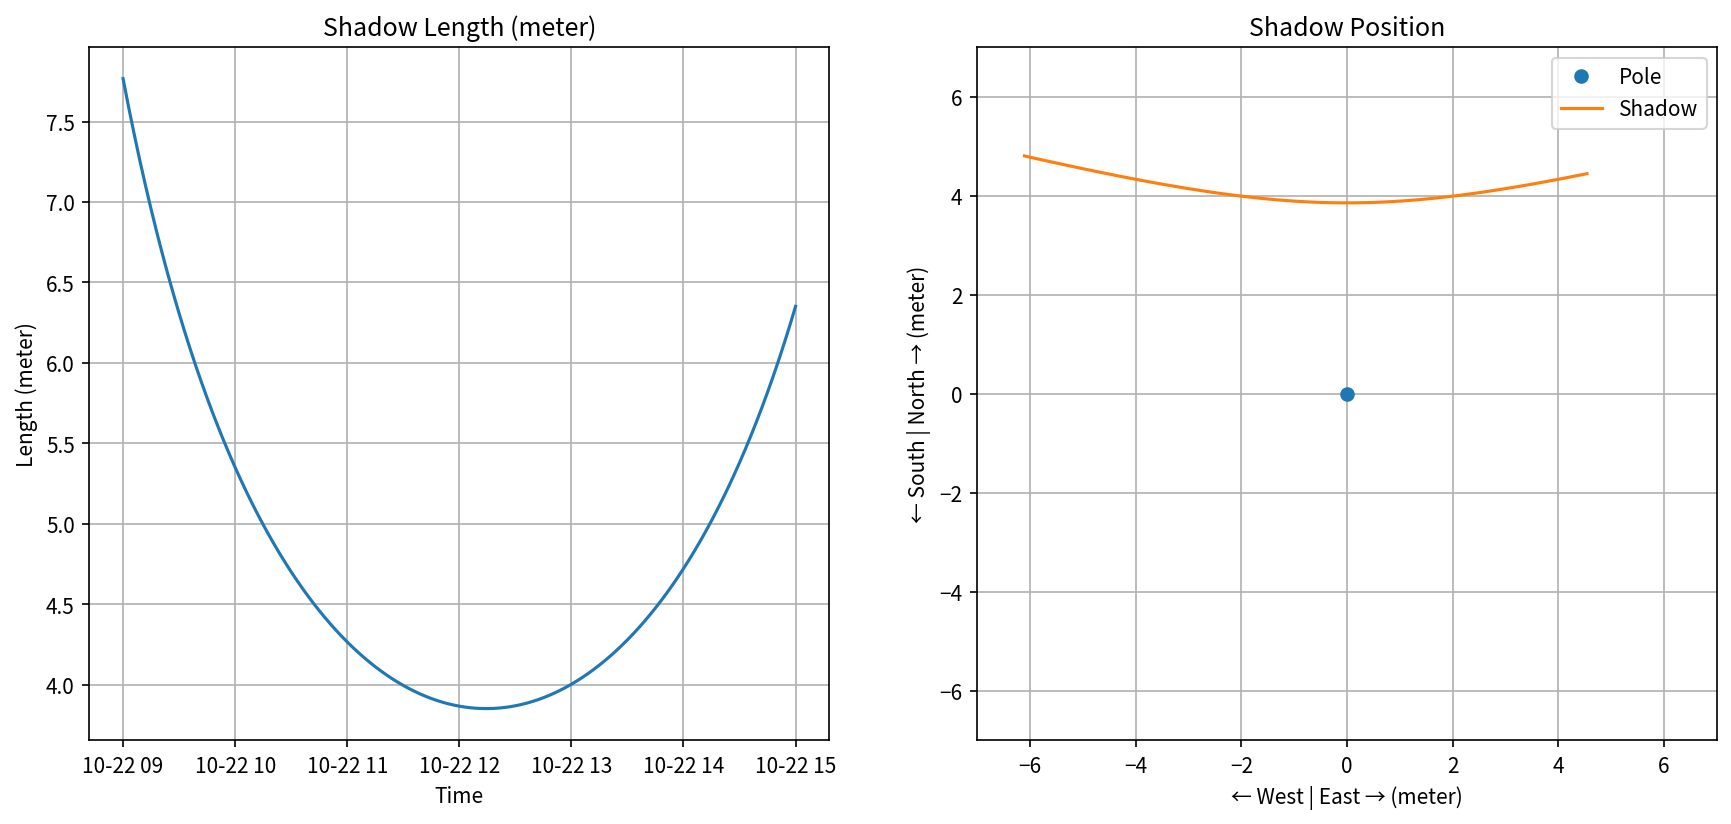

In [151]:
# 问题 1

tian_anmen_longitude = np.deg2rad(116 + 23 / 60 + 29 / 3600)
"""天安门经度，东经 116°23'29"""""
tian_anmen_latitude = np.deg2rad(39 + 54 / 60 + 26 / 3600)
"""天安门纬度，北纬 39°54'26"""""
pole_length = 3
"""竖直直杆长度"""
start_timestamp = datetime.fromisoformat("2015-10-22 09:00:00+08:00").timestamp()
end_timestamp = datetime.fromisoformat("2015-10-22 15:00:00+08:00").timestamp()
step = timedelta(minutes=3).total_seconds()
timestamp_list = np.arange(start_timestamp, end_timestamp + step, step)
x_ticks = np.array([datetime.fromtimestamp(timestamp, CST) for timestamp in timestamp_list])
shadow_length_theoretical = shadow_length(timestamp_list, tian_anmen_longitude, tian_anmen_latitude) * pole_length
shadow_azimuth_theoretical = shadow_azimuth(timestamp_list, tian_anmen_longitude, tian_anmen_latitude)
north_component_theoretical, east_component_theoretical = shadow_position(timestamp_list, tian_anmen_longitude, tian_anmen_latitude) * pole_length

# 输出
print("时间\t影子长度（米）\t影子方位角（度）\t影子北坐标（米）\t影子东坐标（米）")
for date_time, length, azimuth, north, east in zip(x_ticks,
                                                   shadow_length_theoretical,
                                                   shadow_azimuth_theoretical,
                                                   north_component_theoretical,
                                                   east_component_theoretical):
    print(f"{date_time}\t{length:.4f}\t{np.rad2deg(azimuth):.4f}\t{north:.4f}\t{east:.4f}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
ax1.set_title("Shadow Length (meter)")
ax1.set_xlabel("Time")
ax1.set_ylabel("Length (meter)")
ax1.grid()
ax1.plot(x_ticks, shadow_length_theoretical)

ax2.set_title("Shadow Position")
ax2.set_xlabel("← West | East → (meter)")
ax2.set_ylabel("← South | North → (meter)")
ax2.set_xlim(-7, 7)
ax2.set_ylim(-7, 7)
ax2.grid()
ax2.plot(0, 0, "o", label="Pole")
ax2.plot(east_component_theoretical, north_component_theoretical, label="Shadow")
ax2.legend()

plt.show()


In [152]:
# 问题 2 数据

date_part = date.fromisoformat("2015-04-18")
raw_data = """
14:42	1.0365	0.4973
14:45	1.0699	0.5029
14:48	1.1038	0.5085
14:51	1.1383	0.5142
14:54	1.1732	0.5198
14:57	1.2087	0.5255
15:00	1.2448	0.5311
15:03	1.2815	0.5368
15:06	1.3189	0.5426
15:09	1.3568	0.5483
15:12	1.3955	0.5541
15:15	1.4349	0.5598
15:18	1.4751	0.5657
15:21	1.516	0.5715
15:24	1.5577	0.5774
15:27	1.6003	0.5833
15:30	1.6438	0.5892
15:33	1.6882	0.5952
15:36	1.7337	0.6013
15:39	1.7801	0.6074
15:42	1.8277	0.6135
"""
datetime_list = []
x_measured = []
y_measured = []
for line in raw_data.strip().split("\n"):
    time_str, x_str, y_str = line.split("\t")
    hour_num, minute_num = map(int, time_str.split(":"))
    time_part = time(hour_num, minute_num, tzinfo=CST)
    datetime_list.append(datetime.combine(date_part, time_part))
    x_measured.append(float(x_str))
    y_measured.append(float(y_str))
x_measured = np.array(x_measured)
y_measured = np.array(y_measured)


经度：109.21533769109108°
纬度：18.86552332404136°
直杆长度：2.0039361346949502米
坐标系旋转角度：-14.129622702402187°


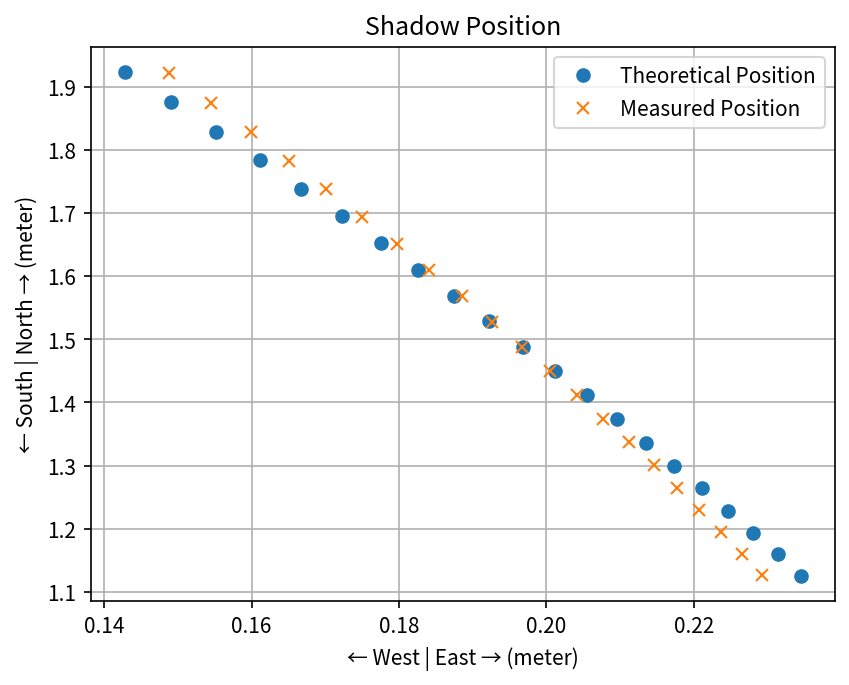

In [153]:
# 问题 2
# 假定附件中的坐标系从天上往地下看，是右手系
# 注意：（北，东）坐标系是左手系！

timestamp_list = np.array([time.timestamp() for time in datetime_list])
shadow_length_measured = np.hypot(x_measured, y_measured)
rotation_measured = np.arctan2(y_measured, x_measured)
measured_center_x = np.mean(x_measured)
measured_center_y = np.mean(y_measured)
measured_center_length = np.hypot(measured_center_x, measured_center_y)
measured_center_rotation = np.arctan2(measured_center_y, measured_center_x)


def measured_position_transformed(pole_length, coordinate_system_rotation):
    """根据给定的直杆长度和坐标系旋转角度，将实测影子位置变换为（北，东）坐标系"""
    east_transformed = shadow_length_measured * np.cos(rotation_measured + coordinate_system_rotation) / pole_length
    north_transformed = shadow_length_measured * np.sin(rotation_measured + coordinate_system_rotation) / pole_length
    return np.array((north_transformed, east_transformed))


def calculate_pole_length_and_rotation(north_theoretical, east_theoretical):
    """通过影子的理论位置推算直杆长度以及坐标系旋转角度，要求理论影子位置的重心与变换后的实测影子位置的重心重合。"""
    theoretical_center_north = np.mean(north_theoretical)
    theoretical_center_east = np.mean(east_theoretical)
    theoretical_center_length = np.hypot(theoretical_center_north, theoretical_center_east)
    theoretical_center_azimuth = np.arctan2(theoretical_center_east, theoretical_center_north)
    pole_length = measured_center_length / theoretical_center_length
    coordinate_system_rotation = np.pi/2 - theoretical_center_azimuth - measured_center_rotation
    return pole_length, coordinate_system_rotation


def target_function(params):
    """文稿中的目标函数"""
    longitude, latitude = params
    shadow_length_theoretical = shadow_length(timestamp_list, longitude, latitude) * pole_length

    t = shadow_length_theoretical
    m = shadow_length_measured
    return np.sum((t[1:] / t[:-1] - m[1:] / m[:-1]) ** 2)


result = optimize.minimize(
    target_function,
    [tian_anmen_longitude, tian_anmen_latitude],
    bounds=[np.deg2rad((-180, 180)), np.deg2rad((-90, 90))],
)  # 此处无需加上太阳高度角 > 0 的约束条件，因为影长计算时把太阳高度角小于 0 的影长设为 NaN 了
# print(result)
assert result.success, "Optimization failed"

longitude, latitude = result.x
north_theoretical, east_theoretical = shadow_position(timestamp_list, longitude, latitude)
pole_length, coordinate_system_rotation = calculate_pole_length_and_rotation(north_theoretical, east_theoretical)
north_transformed, east_transformed = measured_position_transformed(pole_length, coordinate_system_rotation) * pole_length
north_theoretical *= pole_length
east_theoretical *= pole_length

print(f"""经度：{np.rad2deg(longitude)}°
纬度：{np.rad2deg(latitude)}°
直杆长度：{pole_length}米
坐标系旋转角度：{np.rad2deg(coordinate_system_rotation)}°""")

plt.title("Shadow Position")
plt.xlabel("← West | East → (meter)")
plt.ylabel("← South | North → (meter)")
plt.grid()
# plt.xlim(-1, 1)
# plt.ylim(-1, 1)
plt.plot(north_theoretical, east_theoretical, "o", label="Theoretical Position")
plt.plot(north_transformed, east_transformed, "x", label="Measured Position")
plt.legend()
plt.show()


In [154]:
# 问题 3 数据

raw_data = """
12:41	-1.2352	0.173
12:44	-1.2081	0.189
12:47	-1.1813	0.2048
12:50	-1.1546	0.2203
12:53	-1.1281	0.2356
12:56	-1.1018	0.2505
12:59	-1.0756	0.2653
13:02	-1.0496	0.2798
13:05	-1.0237	0.294
13:08	-0.998	0.308
13:11	-0.9724	0.3218
13:14	-0.947	0.3354
13:17	-0.9217	0.3488
13:20	-0.8965	0.3619
13:23	-0.8714	0.3748
13:26	-0.8464	0.3876
13:29	-0.8215	0.4001
13:32	-0.7967	0.4124
13:35	-0.7719	0.4246
13:38	-0.7473	0.4366
13:41	-0.7227	0.4484
"""
# raw_data = """
# 13:09	1.1637	3.336
# 13:12	1.2212	3.3299
# 13:15	1.2791	3.3242
# 13:18	1.3373	3.3188
# 13:21	1.396	3.3137
# 13:24	1.4552	3.3091
# 13:27	1.5148	3.3048
# 13:30	1.575	3.3007
# 13:33	1.6357	3.2971
# 13:36	1.697	3.2937
# 13:39	1.7589	3.2907
# 13:42	1.8215	3.2881
# 13:45	1.8848	3.2859
# 13:48	1.9488	3.284
# 13:51	2.0136	3.2824
# 13:54	2.0792	3.2813
# 13:57	2.1457	3.2805
# 14:00	2.2131	3.2801
# 14:03	2.2815	3.2801
# 14:06	2.3508	3.2804
# 14:09	2.4213	3.2812
# """
time_list = []
x_measured = []
y_measured = []
for line in raw_data.strip().split("\n"):
    time_str, x_str, y_str = line.split("\t")
    hour_num, minute_num = map(int, time_str.split(":"))
    time_list.append(time(hour_num, minute_num, tzinfo=CST))
    x_measured.append(float(x_str))
    y_measured.append(float(y_str))
x_measured = np.array(x_measured)
y_measured = np.array(y_measured)


Optimization failed on 2015-06-12: ABNORMAL_TERMINATION_IN_LNSRCH
Optimization failed on 2016-02-08: ABNORMAL_TERMINATION_IN_LNSRCH
Optimization failed on 2016-02-18: ABNORMAL_TERMINATION_IN_LNSRCH
日期：2015-05-20
经度：79.79011981933792°
纬度：39.25393371480167°
直杆长度：1.9854843137882758米
坐标系旋转角度：-20.13465656383602°
最可能的 5 个时间地点：
日期：2015-05-20	目标函数值：2.52461201840538e-05	经度：79.79011981933792°	纬度：39.25393371480167°
日期：2015-07-22	目标函数值：2.5249115917884407e-05	经度：79.80315749202082°	纬度：39.17382455355974°
日期：2015-07-21	目标函数值：2.5250168417099725e-05	经度：79.77726038328602°	纬度：39.332954802317225°
日期：2015-05-19	目标函数值：2.525949744430113e-05	经度：79.81641713050546°	纬度：39.092571845539105°
日期：2015-05-21	目标函数值：2.5260935585293105e-05	经度：79.76462396839102°	纬度：39.4108188911605°


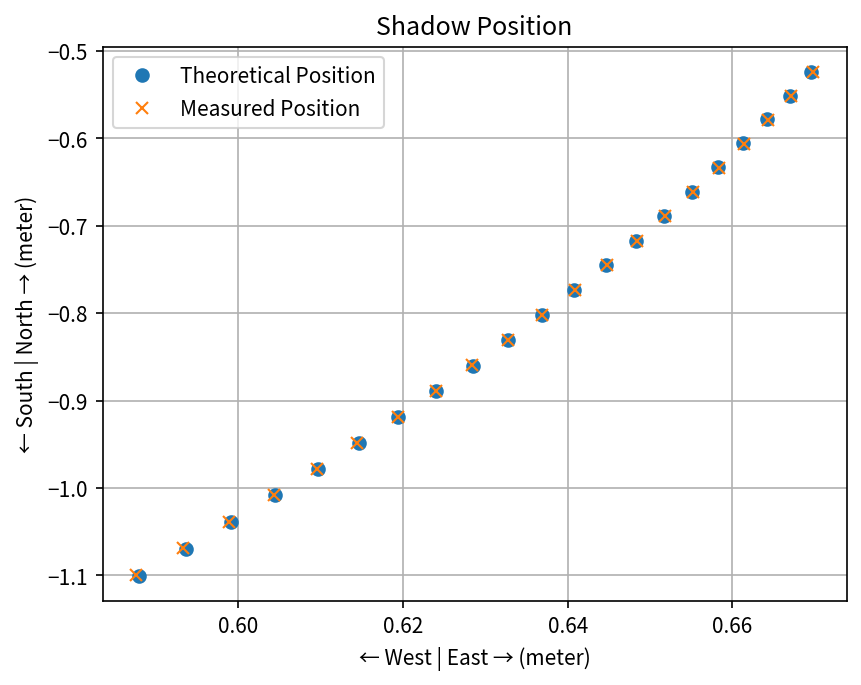

In [155]:
# 问题 3

shadow_length_measured = np.hypot(x_measured, y_measured)
rotation_measured = np.arctan2(y_measured, x_measured)  # 这是在右手系中的旋转角
measured_center_x = np.mean(x_measured)
measured_center_y = np.mean(y_measured)
measured_center_length = np.hypot(measured_center_x, measured_center_y)
measured_center_rotation = np.arctan2(measured_center_y, measured_center_x)

LAMBDA = 1/2

def single_optimization(date_part):
    timestamp_list = np.array([datetime.combine(date_part, time_part).timestamp() for time_part in time_list])

    def target_function(params):
        """文稿中的目标函数"""
        longitude, latitude = params
        shadow_length_theoretical = shadow_length(timestamp_list, longitude, latitude)
        shadow_azimuth_theoretical = shadow_azimuth(timestamp_list, longitude, latitude)

        lt = shadow_length_theoretical
        at = shadow_azimuth_theoretical
        lm = shadow_length_measured
        am = -rotation_measured  # 加个负号从右手系转换到左手系
        return (LAMBDA * np.sum((lt[1:] / lt[:-1] - lm[1:] / lm[:-1]) ** 2) / np.max(lm[1:] / lm[:-1]) ** 2
                + (1 - LAMBDA) * np.sum(((at[1:] - at[:-1]) - (am[1:] - am[:-1])) ** 2) / np.max(abs(am[1:] - am[:-1])) ** 2)


    result = optimize.minimize(
        target_function,
        [tian_anmen_longitude, tian_anmen_latitude],
        bounds=[np.deg2rad((-180, 180)), np.deg2rad((-90, 90))],
    )
    if not result.success:
        print(f"Optimization failed on {date_part}: {result.message}")
    return result


results = []

for day in range(366):  # 枚举 2015 年春分到 2016 年春分
    date_part = march_equinox_2015.astimezone(CST).date() + timedelta(days=day)
    result = single_optimization(date_part)
    if not result.success or np.isnan(result.fun):
        continue
    results.append((date_part, result))

date_part, result = min(results, key=lambda x: x[1].fun)
timestamp_list = np.array([datetime.combine(date_part, time_part).timestamp() for time_part in time_list])
longitude, latitude = result.x
north_theoretical, east_theoretical = shadow_position(timestamp_list, longitude, latitude)
pole_length, coordinate_system_rotation = calculate_pole_length_and_rotation(north_theoretical, east_theoretical)
north_transformed, east_transformed = measured_position_transformed(pole_length, coordinate_system_rotation) * pole_length
north_theoretical *= pole_length
east_theoretical *= pole_length

print(f"""日期：{date_part}
经度：{np.rad2deg(longitude)}°
纬度：{np.rad2deg(latitude)}°
直杆长度：{pole_length}米
坐标系旋转角度：{np.rad2deg(coordinate_system_rotation)}°""")

n = 5
best_n = sorted(results, key=lambda x: x[1].fun)[:n]
print(f"最可能的 {n} 个时间地点：")
for date_part, result in best_n:
    longitude, latitude = result.x
    print(f"日期：{date_part}\t目标函数值：{result.fun}\t经度：{np.rad2deg(longitude)}°\t纬度：{np.rad2deg(latitude)}°")

plt.title("Shadow Position")
plt.xlabel("← West | East → (meter)")
plt.ylabel("← South | North → (meter)")
plt.grid()
# plt.xlim(-1, 1)
# plt.ylim(-1, 1)
plt.plot(north_theoretical, east_theoretical, "o", label="Theoretical Position")
plt.plot(north_transformed, east_transformed, "x", label="Measured Position")
plt.legend()
plt.show()
